<a align = center href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in the city of Toronto, Canada</font></h1>


## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # plotting library
%matplotlib inline 



## 1. Import Data

### scraping with bs4

In [2]:
import requests

URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)

In [3]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page.content, 'html.parser')

In [4]:
mytable = soup.find("table", {"class": "wikitable sortable"})
table_rows = mytable.find_all('tr')

In [5]:
cols = [i.text.replace('\n','').strip() for i in mytable.find_all('th')]
table = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.replace('\n','').strip() for tr in td]
    table.append(row)
table.pop()
df = pd.DataFrame(table, columns= cols)

df.replace(to_replace=['Not assigned'], value=np.nan, inplace=True)
df.dropna(subset = ['Borough'], inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
df.Neighbourhood = df.apply(lambda x: x.Borough if x.Neighbourhood == np.nan else x.Neighbourhood, axis = 1)

In [7]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
print(df.shape)

(103, 3)


### pandas read_html

In [9]:
df2 = pd.read_html(URL, attrs = {'class': 'wikitable sortable'})[0]

In [10]:
df2.replace(to_replace=['Not assigned'], value=np.nan, inplace=True)
df2.dropna(subset = ['Borough'], inplace = True)
df2.reset_index(drop = True, inplace = True)

In [11]:
df2.Neighbourhood = df.apply(lambda x: x.Borough if x.Neighbourhood == np.nan else x.Neighbourhood, axis = 1)

In [12]:
df2.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
print(df2.shape)

(103, 3)


### Getting the latitudes and longitudes

#### Getting the latitudes and longitudes with Nominatim

In [14]:
from geopy.geocoders import Nominatim
import time

#address = '{}, Toronto, Ontario'.format(postal_code)
def get_lat_lng(address, key):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        if key == "lat":
            return latitude
        elif key == "lng":
            return longitude
        else:
            return np.nan
    except:
        return np.nan

In [ ]:
df["Latitude"] = df.apply(lambda x: get_lat_lng('{}, Toronto, Ontario'.format(x["Postal Code"]), "lat"), axis = 1)
df["Longitude"] = df.apply(lambda x: get_lat_lng('{}, Toronto, Ontario'.format(x["Postal Code"]), "lng"), axis = 1)

In [ ]:
df.head()

#### Getting the latitudes and longitudes with geocoder

In [15]:
import geocoder



def get_geocoder(postal_code_from_df):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code_from_df))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [ ]:
df['Latitude'], df['Longitude'] = zip(*df['Postal Code'].apply(get_geocoder))

In [ ]:
df.head()

#### Importing the csv file conatining the latitudes and longitudes for various neighbourhoods in Canada

In [16]:
lat_long = pd.read_csv('https://cocl.us/Geospatial_data')
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
df = pd.merge(
    df,
    lat_long,
    how="left",
    on="Postal Code"
)

In [18]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [19]:
df.shape

(103, 5)

## 2. Explore and cluster the neighborhoods in Toronto

In [20]:
df_Toronto = df[df.Borough.str.contains('Toronto')].reset_index(drop = True)

In [21]:
df_Toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Create a map of Toronto with neighborhoods superimposed on top.


In [22]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

In [23]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.654260, -79.360636], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define Foursquare Credentials and Version

In [24]:
CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' 
CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [25]:
neighborhood_latitude = df_Toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_Toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_Toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


### Let's create a function to get nearby venues to all the neighborhoods in Toronto

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Toronto_venues = getNearbyVenues(names=df_Toronto['Neighbourhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


### Let's check the size of the resulting dataframe

In [28]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1620, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [29]:
Toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,66,66,66,66,66,66
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


## 3. Analyze Each Neighborhood

In [31]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
Toronto_onehot.shape

(1620, 235)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.017241,0.00000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.015152,0.00000,0.000000,0.015152,0.000000,0.015152
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.012658,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012658,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.012658,0.000000,0.000000,0.025316
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.00000,0.000000,0.010000,0.000000,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.028571,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


#### Let's print each neighborhood along with the top 3 most common venues

In [34]:
num_top_venues = 3

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.10
1  Cocktail Bar  0.05
2      Beer Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.13
1       Garden Center  0.07
2       Auto Workshop  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12


----Central Bay Street----
            venue  freq
0     Coffee Shop  0.18
1  Sandwich Place  0.06
2            Café  0.06


----Christie----
           venue  freq
0  Grocery Store  0.25
1           Café  0.19
2           Park  0.12


----Church and Wellesley----
                 venue  freq
0          Coffee

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Restaurant,Beer Bar,Cheese Shop,Seafood Restaurant,Park,Basketball Stadium
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Bakery
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Restaurant,Skate Park,Burrito Place,Fast Food Restaurant,Farmers Market,Garden,Garden Center,Auto Workshop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Rental Car Location,Coffee Shop,Boat or Ferry,Boutique,Airport Gate
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Thai Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Comic Shop,Department Store


## 4. Cluster Neighborhoods

In [37]:
from sklearn.cluster import KMeans

Run _k_-means to cluster the neighborhood into 5 clusters.

In [38]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Selecting _K_

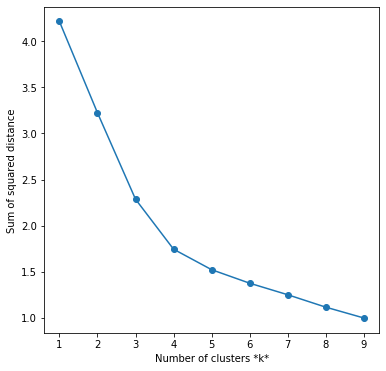

In [39]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Toronto_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');


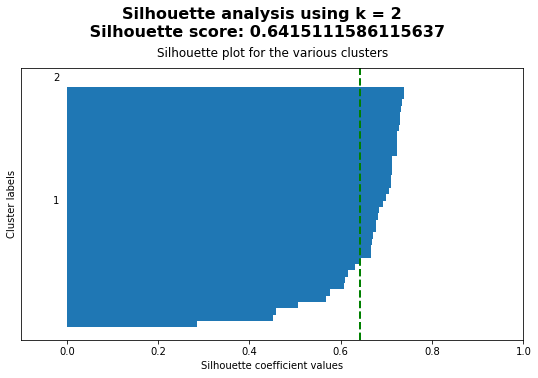

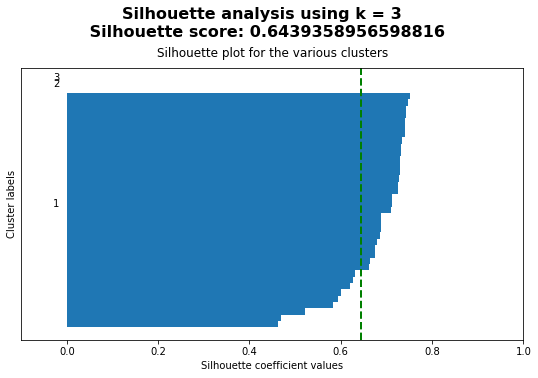

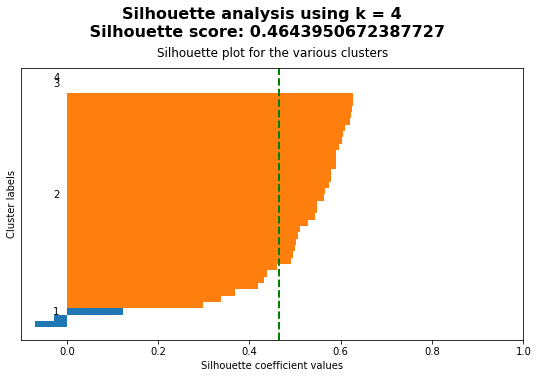

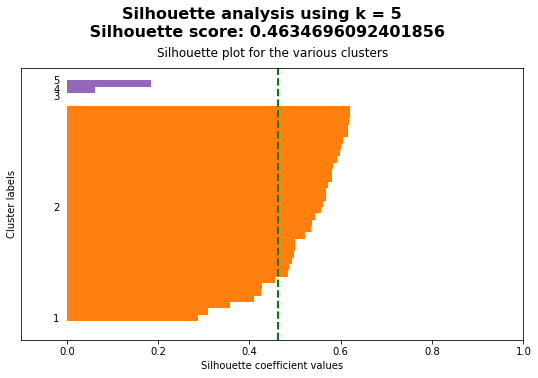

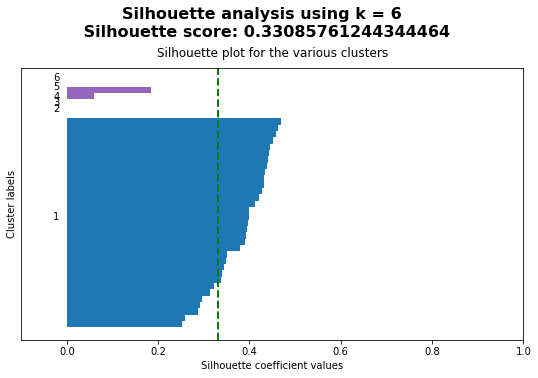

In [40]:
from sklearn.metrics import silhouette_samples

for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(Toronto_grouped_clustering)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(Toronto_grouped_clustering, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.suptitle(f'Silhouette analysis using k = {k} \n Silhouette score: {avg_score}',
                 fontsize=16, fontweight='semibold', y=1.05);

Let's select _k_ = 3

In [41]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [42]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_Toronto

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.merge(neighbourhoods_venues_sorted, on = "Neighbourhood")

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Café,Breakfast Spot,Pub,Theater,Cosmetics Shop,Shoe Store,Brewery
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Creperie,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant,College Auditorium
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Hotel,Middle Eastern Restaurant,Pizza Place,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Cheese Shop,Park,Farmers Market,Seafood Restaurant,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Neighborhood,Coffee Shop,Asian Restaurant,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center


Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[43.654260, -79.360636], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


### Cluster 1

In [44]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Café,Breakfast Spot,Pub,Theater,Cosmetics Shop,Shoe Store,Brewery
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Creperie,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant,College Auditorium
2,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Hotel,Middle Eastern Restaurant,Pizza Place,Fast Food Restaurant
3,Downtown Toronto,0,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Cheese Shop,Park,Farmers Market,Seafood Restaurant,Cosmetics Shop
4,East Toronto,0,Neighborhood,Coffee Shop,Asian Restaurant,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Restaurant,Beer Bar,Cheese Shop,Seafood Restaurant,Park,Basketball Stadium
6,Downtown Toronto,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Thai Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Comic Shop,Department Store
7,Downtown Toronto,0,Grocery Store,Café,Park,Italian Restaurant,Baby Store,Candy Store,Athletics & Sports,Restaurant,Coffee Shop,Nightclub
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Hotel,Deli / Bodega,Thai Restaurant,Concert Hall,Sushi Restaurant,Salad Place
9,West Toronto,0,Bakery,Pharmacy,Grocery Store,Playground,Café,Bar,Bank,Supermarket,Middle Eastern Restaurant,Pool


### Cluster 2

In [45]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1,Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Restaurant,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Cluster 3

In [46]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2,Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
